In [1]:
from langchain.schema import Document
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings


embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
    ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
    ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
    ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
    ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
    ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
    )
]


db = Chroma.from_documents(docs, embedding_function)

retriever = db.as_retriever(search_type="mmr", search_kwargs={"k":3})


In [19]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(model="gpt-4o")

prompt = """
Answer the question based on the context {context}
question: {question}""" 

prompt_template = ChatPromptTemplate.from_template(prompt)

def format_doc(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    prompt_template | llm  | StrOutputParser()
)

# llm_res = chain.invoke("Who founded the gym and what are the timings?")
# llm_res

In [20]:
# first check if user question is related to our product or not
# if question is not related then response with sorry message
# if question is related then get relavant chunks from retriever
# call the llm with retrieved chunks and user question and get final answer
from typing import TypedDict,List
from pydantic import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langchain.schema import Document


class State(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str 


class GradeQuestion(BaseModel):
    "Boolean value to check whether a question is related to the Peak Performance Gym"
    score: str = Field(
        description="Question is about gym? If yes -> 'Yes' if not -> 'No' "
    )

def question_classifyer_node(state: State):
    user_question = state['messages'][-1].content

    system_prompt = """You are a classifier that determines wheater the user's questions belongs to one of the following topics
    1. Gym History & Founder
    2. Operating Hours
    3. Membership Plans 
    4. Fitness Classes
    5. Personal Trainers
    6. Facilities & Equipment

    if user's questions belongs to these questions then response with 'Yes' Otherwise response with 'No'
    """

    grade_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "user question {user_question}"),
    ])

    grade_llm = llm.with_structured_output(GradeQuestion)
    grade_chain = grade_prompt | grade_llm
    respone = grade_chain.invoke({"user_question": user_question})
    
    state["on_topic"] = respone.score

    return state

def off_topic_node(state: State):
    state["messages"] = state["messages"] + [AIMessage(content="Sorry I can't answer this")]
    return state

def retriever_node(state: State):
    response = retriever.invoke(state["messages"][-1].content)
    state["documents"] = format_doc(response)
    return state

def answer_node(state: State):
    question = state["messages"][-1].content
    context = state["documents"]
    response = rag_chain.invoke({"question": question, "context": context})
    state["messages"].append(AIMessage(content=response))


In [21]:
from langgraph.graph import StateGraph,END


def on_topic_router(state: State):
    on_topic_value = state["on_topic"]
    if on_topic_value.lower() == "yes":
        return "on_topic"
    return "off_topic"

workflow = StateGraph(State)
workflow.add_node("question_classifyer_node", question_classifyer_node)
workflow.add_node("off_topic_node",off_topic_node)
workflow.add_node("retriever_node",retriever_node)
workflow.add_node("answer_node",answer_node)

workflow.set_entry_point("question_classifyer_node")
workflow.add_conditional_edges("question_classifyer_node", on_topic_router, {
    "on_topic": "retriever_node",
    "off_topic": "off_topic_node"
})
workflow.add_edge("retriever_node","answer_node")
workflow.add_edge("answer_node",END)
workflow.add_edge("off_topic_node",END)

graph = workflow.compile()


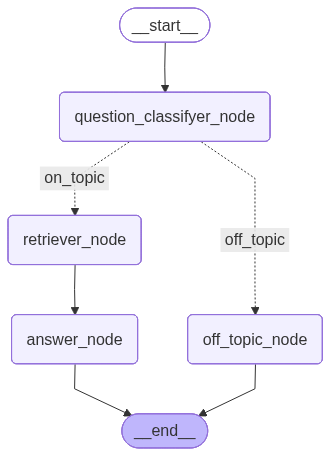

In [17]:
from IPython.display import Image,display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(
graph.get_graph().draw_mermaid_png(
    draw_method=MermaidDrawMethod.API
)
))

In [23]:
res = graph.invoke({
    "messages": [HumanMessage(content="Who is the owner and what are the timings?")]
})
res

{'messages': [HumanMessage(content='Who is the owner and what are the timings?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The owner of Peak Performance Gym is Marcus Chen. The gym is open Monday through Friday from 5:00 AM to 11:00 PM and on weekends from 7:00 AM to 9:00 PM. Members with Premium access have 24/7 entry, including holidays, using their key cards.', additional_kwargs={}, response_metadata={})],
 'documents': 'Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.\n\nOur membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citize

In [24]:
graph.invoke(input={
    "messages": [HumanMessage(content="What does the company Apple do?")]
})

{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Sorry I can't answer this", additional_kwargs={}, response_metadata={})],
 'on_topic': 'No'}